In [1]:
import numpy as np
import pandas as pd
import gc
import time
import pickle

from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import re
import shap
from shap.maskers import Independent

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Où sont les fichiers à charger
pathProject="/Users/anacoluthedev/Dev/Data/home-credit-default-risk/"

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Preprocessing des données
### Repris essentiellement du notebook Kaggle

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df = pd.read_csv(pathProject+'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(pathProject+'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    # code causant l'erreur 'DataFrame' object has no attribute 'append', remplacé, par ces 2 lignes

    df = pd.concat([df, test_df])
    df = df.reset_index(drop=True)
    
    # Categorical features: Binary features and One-Hot encoding
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    del test_df
    gc.collect()
    return df

In [6]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(pathProject+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(pathProject+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(pathProject+'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [8]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(pathProject+'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [9]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(pathProject+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(pathProject+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

   #df["NOM COLONNE"] = pd.to_numeric(df['NOM COLONNE'])


    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [10]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(pathProject+'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [11]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(pathProject+'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(columns = ['SK_ID_PREV'], inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc

    gc.collect()
    return cc_agg

### La fonction du modèle de prédiction Kaggle est trop longue, son appel est mis en commentaire / désactivé ci-dessous

In [12]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1 )

        # Early stopping parameters
        early_stopping_rounds = 10
        best_auc = 0
        best_iteration = 0
        no_improvement = 0



        # Manually implementing early stopping
        for i in range(10000):  # assuming max iterations as 10000
            # Perform one iteration of training
            clf.n_estimators = i + 1
            clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)])

            # Evaluate AUC on validation set
            valid_pred = clf.predict_proba(valid_x)[:, 1]
            current_auc = roc_auc_score(valid_y, valid_pred)

            # Check for improvement
            if current_auc > best_auc:
                best_auc = current_auc
                best_iteration = i + 1
                no_improvement = 0
            else:
                no_improvement += 1

            # Break the loop if no improvement in 'early_stopping_rounds' iterations
            if no_improvement >= early_stopping_rounds:
                print(f"Early stopping: Stopping training at iteration {i+1}")
            break

        # Refit the model with the best iteration
        clf.n_estimators = best_iteration
        clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)])


        model = clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)])

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        # Erreur avec Early stopping
        #clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        #    eval_metric= 'auc', early_stopping_rounds= 100)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    #return feature_importance_df
    return oof_preds, model 


In [13]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

### Fonctions supplémentaires ajoutées, pour traiter les valeurs infinies ou non std

In [14]:
# Preprocessing remplaçant les valeurs infinies par NaN et supprimant les colonnes non numériques
def clean_infinite_and_nonNum(df):
    print("Number of infinite values in the dataframe :", np.isinf(df).values.sum())
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("Are there any infinite values left?:", np.isinf(df).values.any())

    # Identification des colonnes dont le type n'est pas numérique, afin de les supprimer pour les calculs SHAP ultérieurs
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print("Non-numeric columns:", non_numeric_columns)

    df = df.drop(columns=non_numeric_columns)

    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print("Still non-numeric columns, after cleaning:", non_numeric_columns.any())
    return df

In [15]:
# Résolution erreur LightGBMError: Do not support special JSON characters in feature name.

def clean_JSON(df):
    regex = r'[^a-zA-Z0-9\s]'
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(regex, '', regex=True)
    return df

In [16]:
def clean_feature_name(name):
    # Remplacement des caractères JSON avec un underscore
    return re.sub(r'[{}\[\]:;,<>/?\\|`~!@#$%^&*()\-+=\'"]', '_', name)

In [17]:
def clean_all(df):
    df = clean_infinite_and_nonNum(df)
    df = clean_JSON(df)

    # Génération de nom de colonnes sans caractères spéciaux
    cleaned_column_names = [clean_feature_name(name) for name in df.columns]
    # Mise à jout des noms de colonnes du dataframe
    df.columns = cleaned_column_names   
    print("JSON characters cleaned")
    df.columns = [col.replace(' ', '_') for col in df.columns]

    return df

In [18]:
def drop_emptyTARGETs(df):
    # Suppression des lignes TARGET dépourvues de valeur
    df_copy = df.copy()
    n = df_copy.loc[:,'TARGET'].shape[0]
    df_copy.dropna(subset=['TARGET'], inplace=True)
    m = df_copy.loc[:,'TARGET'].shape[0]
    print("Total number of lines before:", n, "Number of lines with the TARGET filled-in:", m)
    return df_copy

### Fonction d'affichage de la ROC ou AUC (Area Under the ROC Curve)

In [19]:
def graphROC(y_true, y_pred_probs, modelName):
    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

    # Calcul de l'AUC (Area Under the ROC Curve)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve '+modelName)
    plt.legend(loc='lower right')

### Pré-traitements de l'ensemble des dataframes source, dans un seul, global, appelé df 

In [20]:
submission_file_name = "submission_kernel26.csv"
num_rows = None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
#with timer("Process credit card balance"):
#        cc = credit_card_balance(num_rows)
#        print("Credit card balance df shape:", cc.shape)
#        df = df.join(cc, how='left', on='SK_ID_CURR')
#        del cc
#        gc.collect()
        
df = clean_all(df)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 122)
Process bureau and bureau_balance - done in 22s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 26s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 14s
Installments payments df shape: (339587, 26)
Process installments payments - done in 33s
Number of infinite values in the dataframe : 61
Are there any infinite values left?: False
Non-numeric columns: Index(['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans',
       'NAME_CONTRACT_TYPE_nan', 'NAME_TYPE_SUITE_Children',
       'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people',
       'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B',
       'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_

In [21]:
df = drop_emptyTARGETs(df)

Total number of lines before: 356255 Number of lines with the TARGET filled-in: 307511


# Analyse exploratoire

<Axes: ylabel='Frequency'>

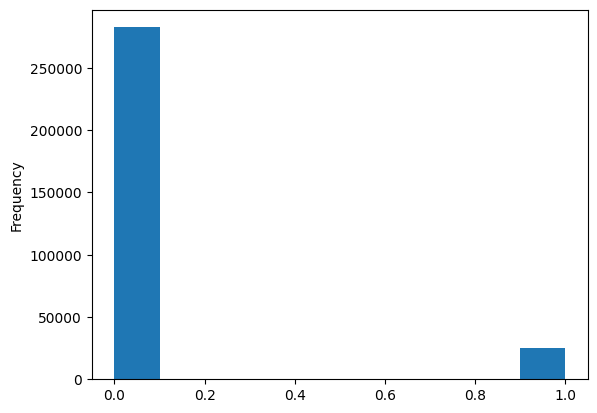

In [22]:
df['TARGET'].astype(int).plot.hist()

Ratio of the repayed credit is 92 %


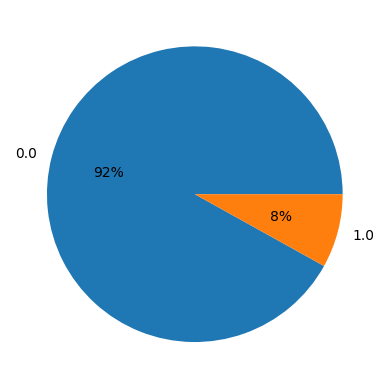

In [23]:
nRepayed = df.loc[(df['TARGET']==0),:].shape[0]
nDefaulted = df.loc[(df['TARGET']==1),:].shape[0]
ratioDefault = nDefaulted / (nRepayed + nDefaulted)

# Calcul du ratio de défault, et du percentile à afficher
percentThreshold = 100 - int(ratioDefault * 100)
print('Ratio of the repayed credit is',percentThreshold,'%')

TargetCredit = df.TARGET.value_counts()
palette_color=sns.color_palette()
plt.pie(TargetCredit,labels=TargetCredit.index,colors=palette_color,autopct='%.0f%%')
plt.show()

### Identification des features qui seraient trop corrélées à la Target

In [24]:
# Fraction du dataset utilisée dans les calculs de corrélation
p = 100
n=int(df.shape[0]/p)
correlations = df.sample(n).corr()

target_correlation = correlations['TARGET'].drop('TARGET', axis=0)

# Elimination des corrélations qui ne sont pas significatives
significant_correlations = target_correlation[abs(target_correlation) > 0.05]
sorted_correlations = significant_correlations.sort_values(ascending=False)

print(sorted_correlations)

PREV_CODE_REJECT_REASON_SCOFR_MEAN                  0.112108
REF_DAYS_DECISION_MAX                               0.100852
BURO_MONTHS_BALANCE_MIN_MIN                         0.097665
REF_AMT_DOWN_PAYMENT_MIN                            0.091027
PREV_NAME_CONTRACT_STATUS_Refused_MEAN              0.083275
ACT_AMT_CREDIT_MAX_OVERDUE_MEAN                     0.078177
BURO_DAYS_CREDIT_MEAN                               0.077132
REF_DAYS_DECISION_MEAN                              0.074948
DAYS_EMPLOYED                                       0.066210
PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN              0.066139
PREV_NAME_CASH_LOAN_PURPOSE_Buying_a_garage_MEAN    0.066139
BURO_DAYS_CREDIT_MIN                                0.065999
BURO_DAYS_CREDIT_ENDDATE_MEAN                       0.065409
ACT_DAYS_CREDIT_MEAN                                0.065150
FLAG_DOCUMENT_2                                     0.065134
DAYS_BIRTH                                          0.064517
BURO_CREDIT_ACTIVE_Activ

# Fonctions de prédiction

### Utilisation de la fonction fournie par le notebook Kaggle, très légèrement modifiée
##### finalement écartée car beaucoup trop longue à exécuter

In [25]:
'''with timer("Run LightGBM with kfold"):
    oof_preds, model = kfold_lightgbm(df, num_folds= 5, stratified = False)
'''

'with timer("Run LightGBM with kfold"):\n    oof_preds, model = kfold_lightgbm(df, num_folds= 5, stratified = False)\n'

## Utilisation d'un LightGBM simple 
#### entrainé avec la librairie lightgbm, très rapide

In [36]:

def simpleLGBM(df):
    # Définition de X_train et de y_train
    train_df = df[df['TARGET'].notnull()].copy()
    y = train_df['TARGET']
    X = train_df.drop(columns= ['TARGET'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Conversion des données en dataset intelligible pour LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Utilisation des paramètres précédents (fournis dans le notbook Kaggle)
    params = {
    'boosting_type': 'gbdt',   # Gradient boosting decision tree
    'objective': 'binary',     # Binary target feature
    'metric': 'binary_logloss',# Metric for binary classification
    'num_leaves': 31,          # Number of leaves in one tree
    'learning_rate': 0.05,     # How much to update the model in each iteration
    'feature_fraction': 0.9,   # The fraction of features to consider in each tree
    'bagging_fraction': 0.8,   # The fraction of data to consider in each iteration
    'bagging_freq': 5,         # Frequency for bagging
    'verbose': 0               # Controls the level of LightGBM's verbosity
    }


    model = lgb.train(params,
                train_data,
                num_boost_round=100,      # Number of boosting iterations
                valid_sets=[train_data, test_data],  # Validation data
                ) # Will stop if no improvement is shown in the given rounds

    # Prédictions avec le modèle fité
    y_pred = model.predict(X, num_iteration=model.best_iteration)
    aucC = roc_auc_score(y, y_pred)
    print(f"The AUC score is: {aucC}")

    # Calculons la valeur au percentile à partir duquel nous observons des défauts, afin de calculer le seuil pour rendre boléennes nos estimations
    valPercentileDefault = np.percentile(y_pred,percentThreshold)

    print('The value above with the credit is most likely to be defaulted is %.6f' % valPercentileDefault)

    #score1 = business_score(y, y_pred)
    #print(f"The business score is: {score1}")

    graphROC(df['TARGET'].values, y_pred, "LightGBM")
    return y_pred, model

The AUC score is: 0.7950852614759097
The value above with the credit is most likely to be defaulted is 0.195335


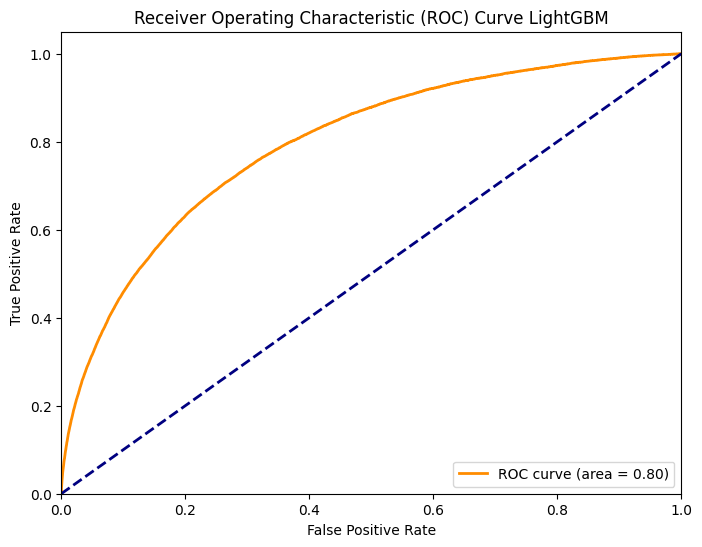

In [37]:
y_pred, model = simpleLGBM(df)

### Distribution des probabilités de défault calculées par le modèle 

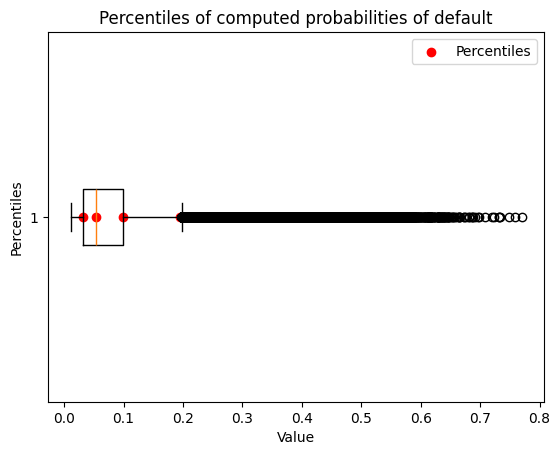

In [38]:
percentiles = np.percentile(y_pred, [25, 50, 75, percentThreshold])

plt.boxplot(y_pred, vert=False)
plt.scatter(percentiles, [1, 1, 1, 1], color='red', marker='o', label='Percentiles')
plt.xlabel('Value')
plt.ylabel('Percentiles')
plt.title('Percentiles of computed probabilities of default')
plt.legend()
plt.show()

### Importance des features, calculée avec SHAP, pour compléter & vérifier le code kaggle

In [41]:
numFeaturesModel = 20

train_df = df[df['TARGET'].notnull()].copy()
y = train_df['TARGET']
X = train_df.drop(columns= ['TARGET'], axis = 1)

# Utilisation d'un sous ensemble du dataset, représentatif pour accélérer le calcul des features
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.01, stratify=y, random_state=42)

print('Size of the dataset for the SHAP computations:',X_sample.shape)
with timer("Compute Shap values for LightGBM"):
    background = Independent(data=X_sample)
    explainer = shap.Explainer(model, background)

    feats = [f for f in X_sample.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']]
    shap_values = explainer.shap_values(X_sample[feats])
    shap.summary_plot(shap_values, X_sample[feats])
    
    # Synthèse des valeurs SHAP de toutes les features pour calculer l'importance relative de chaque feature
    shap_sum = np.abs(shap_values).mean(axis=0)  

    # Selection des features les plus importantes, pour les utiliser par la suite, pour d'autres modèles
    importance_df = pd.DataFrame([X_sample.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['Feature', 'Importance']
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True).head(numFeaturesModel)
    print('Most important features to be used in our model:',importance_df)

Size of the dataset for the SHAP computations: (3075, 527)


 98%|===================| 3005/3075 [00:18<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -3.336538, while the model output was -3.307077. If this difference is acceptable you can set check_additivity=False to disable this check.

### Simplification du dataset pour ne conserver que les features les plus importantes, et la Target

In [33]:
important_features = importance_df['Feature'].tolist()
important_features.append('TARGET')

print('Dataset size before the elimination of the non relevant features:', df.shape)

df_filtered = df[important_features]
print('Dataset size after', df_filtered.shape)


Dataset size before the elimination of the non relevant features: (307511, 528)
Dataset size after (307511, 21)


# Test des performances du m

In [35]:
y_pred, model = simpleLGBM(df_filtered)

KeyError: "['SK_ID_CURR'] not found in axis"

## Calcul d'un score Business, plus adapté à notre cas concret, 
#### et sa mesure en fontion du seuil de conversion de probabilité de défaut, en booléen défaut

In [44]:
# Calcul du Business Score: un crédit accordé qui ne sera pas remboursé est très pénalisant (faux négatif), perte en principal
# contrairement à un crédit refusé qui aurait été remboursé (faux positif) que l'on surpondère dans le calcul
# Ce Business score est ainsi une fonction de cout que l'on cherche à minimiser i.e. minimiser le manque à gagner
def customBusinessScore(tp, tn, fp, fn):
    businessScore = fp  + fn * 10
    return businessScore

In [46]:
def assessPred(df, oof_preds, valPercentileDefault):
    actual_targets = df['TARGET'].values

    # Conversion des probabilités en valeurs booléennes avec notre seuil calculé juste avant
    valPercentileTest = valPercentileDefault
    binary_predictions = np.where(oof_preds > valPercentileTest, 1, 0)

    # Génération de la matrice de confusion
    conf_matrix = confusion_matrix(actual_targets, binary_predictions)

    # Extraction des vrais positifs (true p), faux positifs (false p), faux negatifs (fn) et des vrais positifs (tn)
    tn, fp, fn, tp = conf_matrix.ravel()


    # Extraction de la vérité et des estimations
    y_true = df['TARGET'].values
    y_pred_probs = oof_preds

    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)  

    print("Threshold:", valPercentileDefault)
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")

    # Calcul de precision (qualité de l'estimation des vrais positifs) et de  recall/rappel (capacité à trouver tous les vrais positifs)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # Calcul du F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)


    businessScore = customBusinessScore(tp, tn, fp, fn)
    print(f"Precision Score: {precision:.2f}")
    print(f"Recall Score: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print('Business score:', businessScore)
    print("____________________________________")

    # Initialisation des variables pour déterminer le meilleur score
    best_threshold = None
    best_score = np.inf  # Initialisation à + infini (cout infini, que l'on cherche à minimiser)

    thresholds_list = []
    scores_list = []


    # Détermination de meilleur seuil pour optimiser le business score

    for threshold in thresholds:
        # Conversion des probabilités en booléen en fonction du seuil appelé threshold
        y_pred = (y_pred_probs >= threshold).astype(int)
    
        # Calculs des vrais / faux positifs et négatifs
        tp = np.sum((y_pred == 1) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
    
        # Calcul du score Business
        score = customBusinessScore(tp, tn, fp, fn)
    
        # Stockage du score parmi les scores business calculés pour chacun des seuils testés
        thresholds_list.append(threshold)
        scores_list.append(score)

    
        # Détermination si le score dernièrement calculé est le meilleur, et stockage le cas échéant
        if score < best_score:
            best_score = score
            best_threshold = threshold


    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best Score: {best_score:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds_list, scores_list, marker='o', linestyle='-', color='b')
    plt.xlabel('Threshold')
    plt.ylabel('Business Score')
    plt.title('Business Score vs. Threshold')
    plt.grid(True)
    plt.show()

In [47]:
assessPred(df, y_pred, valPercentileDefault)

NameError: name 'oof_preds' is not defined

In [28]:
# Fonction de calcul de score, utilisable par GridSearchCV, 
# prenant 2 paramètres : les valeurs vraies et celles prédites
# retournant un Business Score

def business_score(y_true, y_pred):
    
    # Conversion des probabilités en valeurs booléennes avec notre seuil calculé juste avant
    binary_predictions = np.where(y_pred > valPercentileDefault, 1, 0)
    
    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_true, binary_predictions)

    # Extraction des résultats
    tn, fp, fn, tp = conf_matrix.ravel()
    score = customBusinessScore(tp, tn, fp, fn)
    print ('Current Business Score:',score)
    return score


In [30]:
# Utilisation d'un simple LightGBM

# Définition de X_train et de y_train
train_df = df[df['TARGET'].notnull()].copy()
y = train_df['TARGET']
X = train_df.drop(columns= ['TARGET', 'SK_ID_CURR'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Conversion des données en dataset intelligible pour LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Utilisation des paramètres précédents
params = {
    'boosting_type': 'gbdt',   # Gradient boosting decision tree
    'objective': 'binary',     # Binary target feature
    'metric': 'binary_logloss',# Metric for binary classification
    'num_leaves': 31,          # Number of leaves in one tree
    'learning_rate': 0.05,     # How much to update the model in each iteration
    'feature_fraction': 0.9,   # The fraction of features to consider in each tree
    'bagging_fraction': 0.8,   # The fraction of data to consider in each iteration
    'bagging_freq': 5,         # Frequency for bagging
    'verbose': 0               # Controls the level of LightGBM's verbosity
}

gbm = lgb.train(params,
                train_data,
                num_boost_round=100,      # Number of boosting iterations
                valid_sets=[train_data, test_data],  # Validation data
                ) # Will stop if no improvement is shown in the given rounds

# Prédictions avec le modèle fité
y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
aucC = roc_auc_score(y, y_pred)
print(f"The AUC score is: {aucC}")

# Calculons la valeur au percentile à partir duquel nous observons des défauts, afin de calculer le seuil pour rendre boléennes nos estimations
valPercentileDefault = np.percentile(y_pred,percentThreshold)

print('The value above with the credit is most likely to be defaulted is %.6f' % valPercentileDefault)

score1 = business_score(y, y_pred)
print(f"The business score is: {score1}")



The AUC score is: 0.7954082025356543
The value above with the credit is most likely to be defaulted is 0.194383
Current Business Score: 179043
The business score is: 179043


In [ ]:
# Définition d'une fonction scorer utilisable par GridSearchCV
business_scorer = make_scorer(business_score, greater_is_better=False,needs_proba=True)

## Modèles naifs mesurant la qualité de notre LightGBM

In [ ]:
def testDummyC(df):
    # Separation des Targets, des features
    X = df.drop(columns=['TARGET'])  
    y = df['TARGET']  

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


    # DummyClassifier pour la classification
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train, y_train)
    y_pred_probs = dummy_clf.predict_proba(X_test)[:, 1]  # Probabilités de la bonne classe

    graphROC(y_test, y_pred_probs, "DummyRegressor")

In [ ]:
def testLogisticR(df):
    # Separation des Targets, des features
    X = df.drop(columns=['TARGET'])  
    y = df['TARGET']  

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter if needed for convergence
    log_reg.fit(X_train, y_train)

    # Predicting probabilities for the test set
    y_pred_probs = log_reg.predict_proba(X_test)[:, 1]

    graphROC(y_test, y_pred_probs, 'LogisticRegression')

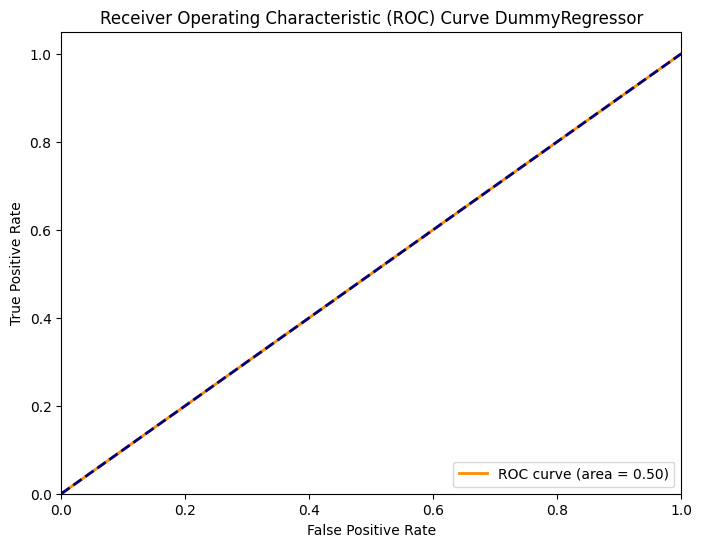

In [ ]:
testDummyC(df)

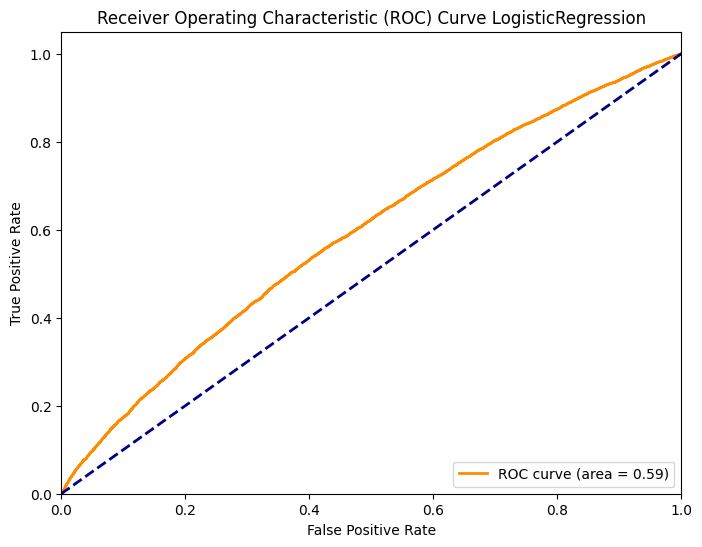

In [ ]:
testLogisticR(df)

In [ ]:
'''
# Problème de convergence, avec GridSearchCV, même si le score est correctement calculé - temps de calcul ?
# Préparation du dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()

# Définition des paramètres à rechercher
param_grid = {
    'num_leaves': [34],
    'learning_rate': [0.5],
    'n_estimators': [1000],
}




# Initialisation GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring=business_scorer, cv=5, verbose=1)

# Fit
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et meilleur score
print("Best parameters found: ", grid_search.best_params_)
print("Best business score found: ", grid_search.best_score_)
'''

'\n# Problème de convergence, avec GridSearchCV, même si le score est correctement calculé - temps de calcul ?\n# Préparation du dataset\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nmodel = lgb.LGBMClassifier()\n\n# Définition des paramètres à rechercher\nparam_grid = {\n    \'num_leaves\': [34],\n    \'learning_rate\': [0.5],\n    \'n_estimators\': [1000],\n}\n\n\n\n\n# Initialisation GridSearchCV\ngrid_search = GridSearchCV(model, param_grid, scoring=business_scorer, cv=5, verbose=1)\n\n# Fit\ngrid_search.fit(X_train, y_train)\n\n# Meilleurs paramètres et meilleur score\nprint("Best parameters found: ", grid_search.best_params_)\nprint("Best business score found: ", grid_search.best_score_)\n'

## Fonction de prédiction LightGBM avec recherche des hyperparamètres

In [ ]:
# Mise en oeuvre d'un GridSearch, spécifique à l'aide d'un early stopping dédié
def lightGBMGrid(X_train, X_test, y_train, y_test, param_grid, modelNameX, smoteT):

    # Initialisation à +infini, du business score, qui est un cout à minimiser
    best_cost = float('inf')
    best_params = None
    cost_improvement_threshold = 1000  # Taille minimale de l'amélioration nécessaire pour continuer à rechercher les meilleurs paramètres
    last_cost = float('inf')

    # Setup K-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    print('Sets of hyperparameters to be tested:', param_grid)
    if smoteT:
        print('Training with SMOTE')
        # 92% des crédits sont remboursés, les données sont très déséquilibrées
        # Utilisons SMOTE (Synthetic Minority Over-sampling Technique) pour corriger le déséquilibre du dataset
        # en créant de nouvelles données synthétiques en interpolant des examples
        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Conversion de X_train_smote en dataframe
        X_train_smote_df = pd.DataFrame(X_train_smote, columns=X.columns)
        X_train = X_train_smote_df
        y_train = y_train_smote

        cost_improvement_threshold = 1000

    for params in ParameterGrid(param_grid):
        costs = []
        auc_scores = []
        print('Training with the following parameters:', params)
    
        for train_index, val_index in kf.split(X_train):
            #print("Number of train indexes:", train_index.shape[0])  
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
            # Création des datasets lightGBM
            lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
            lgb_val = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_train)
        
            # Entrainement des modèles sans les stopping rounds
            model = lgb.train(params,
                                lgb_train,
                                num_boost_round=10000, 
                                valid_sets=[lgb_val])
        
            # Predict du fold
            y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
        
            # Calcul du business score (fonction cout que l'on cherche à minimiser)
            cost = business_score(y_val_fold, y_pred)
            costs.append(cost)

            auc_score = roc_auc_score(y_val_fold, y_pred)
            auc_scores.append(auc_score)
    
        # Calcul de la moyenne des couts de l'ensemble des folds
        avg_cost = np.mean(costs)
        mean_test_AUC = np.mean(auc_scores)
        print("Average business score:", avg_cost)
        # print("Average AUC:", mean_test_AUC)
        print("________________________________")
    
        if avg_cost < best_cost:
            best_cost = avg_cost
            best_params = params
            improvement = (last_cost - avg_cost) / last_cost
            print("Current improvements:", improvement)
            if improvement < cost_improvement_threshold:
                print("Stopping search due to insufficient cost improvement.")
                break
        else:
            improvement = (last_cost - avg_cost) / last_cost
            if improvement < cost_improvement_threshold:
                print("Stopping search due to insufficient cost improvement.")
                break
    
        last_cost = avg_cost

    print(f"Best parameters: {best_params}")
    print(f"Lowest average cost: {best_cost}")
    oof_preds = model.predict(X_test)
    graphROC(y_test, oof_preds, modelNameX)
    return model

In [ ]:
'''
param_grid = {
    'verbose': [-1],
    'learning_rate': [0.1],         # Taux d'apprentissage
    'reg_lambda': [0, 0.5],
    'num_leaves': [34],

}
'''

"\nparam_grid = {\n    'verbose': [-1],\n    'learning_rate': [0.1],         # Taux d'apprentissage\n    'reg_lambda': [0, 0.5],\n    'num_leaves': [34],\n\n}\n"

In [ ]:
            
param_grid = {
            'verbose': [-1],
            'nthread': [4],
            'n_estimators': [10000],
            'learning_rate': [0.02],
            'num_leaves': [10, 34],
            'colsample_bytree': [0.9497036],
            'subsample': [0.8715623],
            'max_depth': [8],
            'reg_alpha': [0.041545473],
            'reg_lambda': [0.0735294],
            'min_split_gain': [0.0222415],
            'min_child_weight': [39.3259775],
           }

Sets of hyperparameters to be tested: {'verbose': [-1], 'nthread': [4], 'n_estimators': [10000], 'learning_rate': [0.02], 'num_leaves': [10, 34], 'colsample_bytree': [0.9497036], 'subsample': [0.8715623], 'max_depth': [8], 'reg_alpha': [0.041545473], 'reg_lambda': [0.0735294], 'min_split_gain': [0.0222415], 'min_child_weight': [39.3259775]}
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 10000, 'nthread': 4, 'num_leaves': 10, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 25722


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 25359


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 25217


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 24785


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 25117
Average business score: 25240.0
________________________________
Current improvements: nan
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 10000, 'nthread': 4, 'num_leaves': 34, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


invalid value encountered in scalar divide
Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 26351


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 26323


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 25961


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 25897


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 25902
Average business score: 26086.8
________________________________
Stopping search due to insufficient cost improvement.
Best parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 10000, 'nthread': 4, 'num_leaves': 10, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}
Lowest average cost: 25240.0


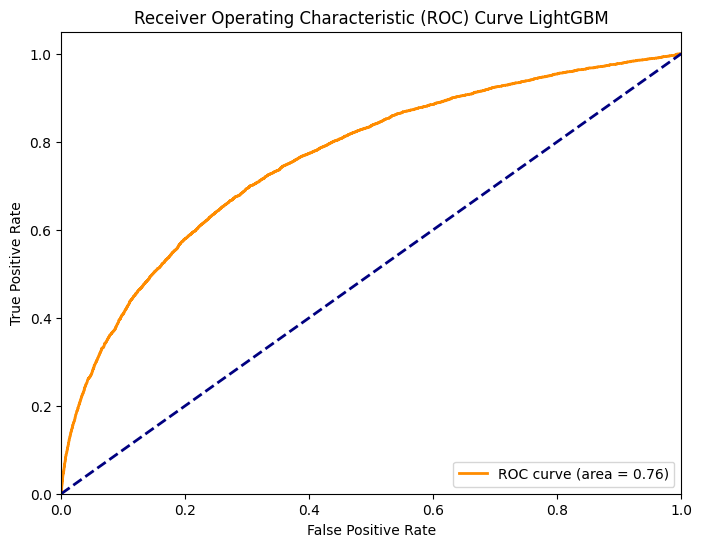

In [ ]:
# Définition de X_train et de y_train
train_df = df[df['TARGET'].notnull()].copy()
y = train_df['TARGET']
X = train_df.drop(columns= ['TARGET', 'SK_ID_CURR'], axis = 1)
X.columns = [col.replace(' ', '_') for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lightGBMGrid(X_train, X_test, y_train, y_test, param_grid, 'LightGBM', False)

In [ ]:
model_filename = pathProject+'lgb_model.pkl'

# Sauvegarde du modèle entrainé, en mode binaire
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

### Nouvel entrainement en corrigeant le déséquilibre des données (peu de défauts)

In [ ]:
# Définition de X_train et de y_train
train_df = df[df['TARGET'].notnull()].copy()
y = train_df['TARGET']
X = train_df.drop(columns= ['TARGET', 'SK_ID_CURR'], axis = 1)

X.columns = [col.replace(' ', '_') for col in X.columns]

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lightGBMGrid(X_train, X_test, y_train, y_test, param_grid, 'LightGBM', True)


Sets of hyperparameters to be tested: {'verbose': [-1], 'nthread': [4], 'n_estimators': [10000], 'learning_rate': [0.02], 'num_leaves': [10, 34], 'colsample_bytree': [0.9497036], 'subsample': [0.8715623], 'max_depth': [8], 'reg_alpha': [0.041545473], 'reg_lambda': [0.0735294], 'min_split_gain': [0.0222415], 'min_child_weight': [39.3259775]}
Training with SMOTE
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 10000, 'nthread': 4, 'num_leaves': 10, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


Found `n_estimators` in params. Will use it instead of argument


KeyboardInterrupt: 

# Sauvegardes des données pré-processées et du modèle entrainé

In [ ]:
model_filename = pathProject+'lgb_model.pkl'

# Sauvegarde du modèle entrainé, en mode binaire
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Sauvegarde du dataframe, prétraité, pour son utilisation dans d'autres notebooks
df_filename = pathProject+'preprocessed_dataframe.csv'

df.to_csv(df_filename, index=False)